<h1 style="font-size:220%"> Analyzing CIA Factbook Data Using SQL</h1>

***

This project aims to study the compendium of statistics about all the countries by working with this [dataset](factbook.db) from the CIA World Factbook.The World Factbook provides basic intelligence on the history, people, government, economy, energy, geography, environment, communications, transportation, military, terrorism, and transnational issues for 266 world entities[$^{[1]}$](https://www.cia.gov/the-world-factbook/). The scope of this project focuses on the demographic indicators like population, mortality, and fertility.

<h1 style="font-size:160%"> TABLE OF CONTENTS </h1>

<a id="0"></a>

>- [Connect to Database File](#1)
>- [Summary of Database File](#2)
>- [Summary of Statistics](#3)
>- [Population](#4)
>    - [A) Top 5 Countries in Population](#5)
>    - [B) Least 5 Dependencies in Total Population](#6)
>- [Population Density](#7)
>    - [A) Countries with the Highest Population Density](#8)
>    - [B) Countries with the Lowest Population Density](#9)
>- [Mortality and Fertility](#10)
>    - [A) Countries with the Highest Birth Rates](#11)
>    - [B) Countries with the Lowest Birth Rates](#12)
>    - [C) Countries with the Highest Death Rates](#13)
>    - [D) Countries with the Lowest Death Rates](#14)
>- [Population Decline by Country](#15)
>- [Conclusion](#16)
>- [References](#17)

<a id="1"></a>
<h1 style="font-size:160%"> Connect to Database File</h1>

***

In [1]:
%%capture
%load_ext sql
%sql sqlite:///factbook.db

<a id="2"></a>
<h1 style="font-size:160%"> Summary of Database File</h1> 

***

#### Return information on the tables

In [2]:
%%sql
SELECT *
    FROM sqlite_master
    WHERE type='table';

 * sqlite:///factbook.db
Done.


type,name,tbl_name,rootpage,sql
table,sqlite_sequence,sqlite_sequence,3,"CREATE TABLE sqlite_sequence(name,seq)"
table,facts,facts,47,"CREATE TABLE ""facts"" (""id"" INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL, ""code"" varchar(255) NOT NULL, ""name"" varchar(255) NOT NULL, ""area"" integer, ""area_land"" integer, ""area_water"" integer, ""population"" integer, ""population_growth"" float, ""birth_rate"" float, ""death_rate"" float, ""migration_rate"" float)"


In [3]:
%%sql
SELECT *
    FROM sqlite_sequence
    LIMIT 5;

 * sqlite:///factbook.db
Done.


name,seq
facts,261


<h1 style="font-size:80%"> Table 1: sqlite_sequence </h1>

In [4]:
%%sql
SELECT *
    FROM facts
    LIMIT 5;

 * sqlite:///factbook.db
Done.


id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate
1,af,Afghanistan,652230,652230,0,32564342,2.32,38.57,13.89,1.51
2,al,Albania,28748,27398,1350,3029278,0.3,12.92,6.58,3.3
3,ag,Algeria,2381741,2381741,0,39542166,1.84,23.67,4.31,0.92
4,an,Andorra,468,468,0,85580,0.12,8.13,6.96,0.0
5,ao,Angola,1246700,1246700,0,19625353,2.78,38.78,11.49,0.46


<h1 style="font-size:80%"> Table 2: facts </h1>

There are two tables in this database file. Sqlite_sequence table is a summary of facts table. There are 261 entries in total. Facts table is the table this project will be studying.

<a id="3"></a>
<h1 style="font-size:160%"> Summary of Statistics</h1>

***

There are 11 columns in total:

|Columns||Description|
|---||:------------------|
|id||Row number|
|code||ISO code for selected world entity|
|name||Name of world entity|
|area||Total area of world entity in km$^{2}$|
|area_land||Total land area in km$^{2}$|
|area_water||Total water area in km$^{2}$|
|population||Total population|
|population_growth||population growth in percentage|
|birth_rate||the number of live births per thousand of population per year|
|death_rate||the number of deaths per thousand of population per year|
|migration_rate||the number of immigrants per thousand of population per year| 

#### Confirm the info from sqlite_sequence

In [5]:
%%sql 
SELECT COUNT(*) as number_of_entries,COUNT(DISTINCT name) as unique_world_entity
    FROM facts;

 * sqlite:///factbook.db
Done.


number_of_entries,unique_world_entity
261,261


The categories of listed entries include: [$^{[2]}$](https://en.wikipedia.org/wiki/The_World_Factbook#:~:text=Entities%20listed,-Main%20article%3A%20List&text=The%20CIA%20defines%20these%20as,category%2C%20there%20are%20195%20entities.&text=Places%20set%20apart%20from%20the,Taiwan%20and%20the%20European%20Union.)

|Categories||Description|
|---||:------------------|
|Independent countries||The CIA defines these as people "politically organized into a sovereign state with a definite territory." In this category, there are 195 entities.|
|Others||Places set apart from the list of independent countries. Currently there are two: Taiwan and the European Union.|
|Dependencies and Areas of Special Sovereignty||Places affiliated with another country. They may be subcategorized by affiliated country.|
|Miscellaneous||Antarctica and places in dispute. There are six such entities.|
|Other entities||The World and the oceans. There are five oceans and the World (the World entry is intended as a summary of the other entries)|

The following table are entities that are not countries:

In [6]:
%%sql
SELECT *
    FROM facts
    WHERE name LIKE '%Union%'
    OR name LIKE '%ocean%';

 * sqlite:///factbook.db
Done.


id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate
197,ee,European Union,4324782,None,None,513949445,0.25,10.2,10.2,2.5
228,io,British Indian Ocean Territory,54400,60,54340,None,None,None,None,None
256,xq,Arctic Ocean,None,None,None,None,None,None,None,None
257,zh,Atlantic Ocean,None,None,None,None,None,None,None,None
258,xo,Indian Ocean,None,None,None,None,None,None,None,None
259,zn,Pacific Ocean,None,None,None,None,None,None,None,None
260,oo,Southern Ocean,None,None,None,None,None,None,None,None


<a id="4"></a>
<h1 style="font-size:160%"> Population</h1>

***

#### Calculating summary of population and look for any outlier countries.

In [7]:
%%sql
SELECT  MIN(population) as Min_Population ,
        CAST(ROUND(AVG(population))AS INT) as AVG_Population,
        MAX(population) as Max_Population
    FROM facts;

 * sqlite:///factbook.db
Done.


Min_Population,AVG_Population,Max_Population
0,62094928,7256490011


There are two findings in the results.
- There is a world entity with 0 population
- There is a world entity with close to the total amount population of the world [$^{[3]}$](https://www.worldometers.info/world-population/)

To figure out the outliers, we would find the min and max entries of the data

#### Entry with minimum and maximum population

In [8]:
%%sql
SELECT *
    FROM facts
    WHERE population == (SELECT MIN(population)
                        FROM facts
                     )
    OR population == (SELECT MAX(population)
                        FROM facts
                     );

 * sqlite:///factbook.db
Done.


id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate
250,ay,Antarctica,None,280000,None,0,None,None,None,None
261,xx,World,None,None,None,7256490011,1.08,18.6,7.8,None


Antarctica is a unique continent in that it does not have a native population due to the unforgiving climate and terrain, although a few thousand people are located there on a temporary basis at one of the many research stations.[$^{[4]}$](https://education.nationalgeographic.org/resource/antarctica)


The table has also included the world as one of entries. Another interesting finding is that the total population of the world could reflect the year when this dataset is collected. 7.25 billion falls somewhere between 2013-2014.[$^{[5]}$](https://www.worldometers.info/world-population/world-population-by-year/)

Taking the above findings into consideration, this is the summary statistics:

#### Calculating summary of population, omitting World

In [9]:
%%sql
SELECT  MIN(population) as Min_Population ,
        CAST(ROUND(AVG(population))as INT) as AVG_Population,
        MAX(population) as Max_Population
        
    FROM facts
    WHERE name <> "World"
    AND name NOT LIKE '%Union%'
    AND name NOT LIKE '%ocean%'
    

 * sqlite:///factbook.db
Done.


Min_Population,AVG_Population,Max_Population
0,30235555,1367485388


#### Calculating summary of population, omitting World and 0 population

In [10]:
%%sql
SELECT  MIN(population) as Min_Population ,
        CAST(ROUND(AVG(population))AS INT) as AVG_Population,
        MAX(population) as Max_Population
        
    FROM facts
    WHERE name <> "World"
    AND name NOT LIKE '%Union%'
    AND name NOT LIKE '%ocean%'
    AND population <> 0;

 * sqlite:///factbook.db
Done.


Min_Population,AVG_Population,Max_Population
48,30362064,1367485388


Minimum population without including world and entities with no population is 48.Average popluation is around 30 million. Maximum population is around 1 billion 36 million.

<a id="5"></a>
<h1 style="font-size: 135%">A) Top 5 Countries in Population</h1>

In [11]:
%%sql 
SELECT name AS "Country" ,
       population,
        ROUND(
                100*
                population / 
                (SELECT CAST(MAX(population)AS Float) FROM facts) 
            ,3) AS percent

FROM facts
WHERE population <> 0
AND name <> "World"
AND name NOT LIKE "%Union%"
-- omit European Union
ORDER BY 2 DESC
LIMIT 5

 * sqlite:///factbook.db
Done.


Country,population,percent
China,1367485388,18.845
India,1251695584,17.249
United States,321368864,4.429
Indonesia,255993674,3.528
Brazil,204259812,2.815


In [12]:
%%sql 
WITH T1 AS (SELECT name AS "Country" ,
       population,
        ROUND(
                100*
                population / 
                (SELECT CAST(MAX(population)AS Float) FROM facts) 
            ,3) AS percent

FROM facts
WHERE population <> 0
AND name <> "World"
AND name NOT LIKE "%Union%"
-- omit European Union
ORDER BY 2 DESC
LIMIT 5)

SELECT 
    SUM(population) AS total_population,
    CAST(ROUND(SUM(percent))AS INT) AS total_percent
FROM T1

 * sqlite:///factbook.db
Done.


total_population,total_percent
3400803322,47


- Top 5 countires in total population are China,India,United States,Indonesia,Brazil. They have a combined population of 3 billion 4 hundred million and contribute 47% to the global population.
- China has the most population of 1 billion 3 hundred million and contribute 19% to the global population.

<a id="6"></a>
<h1 style="font-size: 135%">B) Least 5 Dependencies in Total Population</h1>

In [13]:
%%sql 
SELECT name AS "Dependency" ,
       population

FROM facts
WHERE population <> 0
AND name <> "World"
AND name NOT LIKE "%Union%"
-- omit European Union
ORDER BY 2 
LIMIT 5

 * sqlite:///factbook.db
Done.


Dependency,population
Pitcairn Islands,48
Cocos (Keeling) Islands,596
Holy See (Vatican City),842
Niue,1190
Tokelau,1337


In [14]:
%%sql 
WITH T1 AS (SELECT name AS "Dependency" ,
       population

FROM facts
WHERE population <> 0
AND name <> "World"
AND name NOT LIKE "%Union%"
-- omit European Union
ORDER BY 2
LIMIT 5)

SELECT 
    SUM(population) AS total_population
FROM T1

 * sqlite:///factbook.db
Done.


total_population
4013


- Least 5 Dependencies in total population are Pitcairn Islands, Cocos (Keeling) Islands, Holy See (Vatican City), Niue, Tokelau. They have a combined population of 4 thousand.
- Pitcairn Islands have the least population of 48.

<a id="7"></a>
<h1 style="font-size:160%"> Population Density</h1>

***

The number of individuals living within that specific location determines the population density, or the number of individuals divided by the size of the area. Population density can be used to describe the location, growth, and migration of many organisms.[$^{[6]}$](https://education.nationalgeographic.org/resource/population-density)

According to the table of columns, the equation of population density would be:

\begin{equation}
{Population \, Density}=\frac{population}{area \, land(km^{2})}
\end{equation}

#### Scan summary of population and area land to look for outliers

In [15]:
%%sql
SELECT COUNT(*)
  FROM facts
WHERE population = 0
OR population IS NULL
OR area_land = 0
OR area_land IS NULL;

 * sqlite:///factbook.db
Done.


COUNT(*)
29


There are in total 29 entries that either have population and/or land area is 0 and/or null. These entries would be excluded from the calculation of population density.

<a id="8"></a>
<h1 style="font-size: 135%">A) Countries with the Highest Population Density</h1> 

In [16]:
%%sql
WITH T1 AS (SELECT name
                        FROM facts
                        WHERE population =0
                        OR population IS null
                        OR area_land= 0
                        OR area_land IS null)
SELECT  name,
        area_land,
        population,
        CAST(CAST(population AS FLOAT)/ CAST(area_land AS FLOAT)AS INT) AS population_density
FROM facts
WHERE name NOT IN t1
ORDER BY 4 DESC
LIMIT 10;

 * sqlite:///factbook.db
Done.


name,area_land,population,population_density
Macau,28,592731,21168
Monaco,2,30535,15267
Singapore,687,5674472,8259
Hong Kong,1073,7141106,6655
Gaza Strip,360,1869055,5191
Gibraltar,6,29258,4876
Bahrain,760,1346613,1771
Maldives,298,393253,1319
Malta,316,413965,1310
Bermuda,54,70196,1299


Macao Special Administrative Region of the People's Republic of China holds the highest population density of the world at 21168 person per km$^{2}$. Monaco holds the second place, followed by Singapore, Hong Kong and Gaza Strip.

Other than Singapore, the top five entities are either special adminstrative areas or self-governing territories. However, the scope of this project aims to figure out the population density from a more general persepctive. With that in mind, there needs to be a better definition to identify the entities this project is looking for.

An intuitive approach would be identifying countries that fulfill the followings:
    
For a densely populated country or territory:

WHERE 

- Population > Average values for population.
- LAND AREA < Average values for area.

In [17]:
%%sql
WITH T1 AS (SELECT name
                        FROM facts
                        WHERE population =0
                        OR population IS null
                        OR area_land= 0
                        OR area_land IS null
                        OR name LIKE '%Union%'
                        OR name LIKE '%ocean%'),

T2 AS(SELECT  name,
        area_land,
        population,
        CAST(CAST(population AS FLOAT)/ CAST(area_land AS FLOAT)AS INT) AS population_density
FROM facts
WHERE name NOT IN t1)

SELECT *
FROM T2
WHERE population > (SELECT AVG(population)FROM T2)
AND area_land<(SELECT AVG(population)FROM T2)
ORDER BY 4 DESC
LIMIT 10;

 * sqlite:///factbook.db
Done.


name,area_land,population,population_density
Bangladesh,130170,168957745,1297
"Korea, South",96920,49115196,506
India,2973193,1251695584,420
Japan,364485,126919659,348
Philippines,298170,100998376,338
Vietnam,310070,94348835,304
United Kingdom,241930,64088222,264
Pakistan,770875,199085847,258
Germany,348672,80854408,231
Nepal,143351,31551305,220


The results have greatly improved and show population density from a national perspective. However, the definition that was applied seems to be too vauge. Not only does it rule out too many entries, using average as the cutoff does not provide a lot of information.

Since the project wants to exclude extreme cases with very small land area. A more informative approach would be using percentile of land area as a condition. This way the project have the flexibility to reflect information in different scales.

In [18]:
%%sql 
SELECT name,
       area,
       ROUND(percent_rank() over(ORDER BY area_land ASC)*100,2) as percentile
from facts
WHERE name NOT IN (SELECT name
                        FROM facts
                        WHERE population =0
                        OR population IS null
                        OR area_land= 0
                        OR area_land IS null
                        OR name LIKE '%Union%'
                        OR name LIKE '%ocean%')
LIMIT 10;

 * sqlite:///factbook.db
Done.


name,area,percentile
Monaco,2,0.0
Gibraltar,6,0.43
Tokelau,12,0.87
Cocos (Keeling) Islands,14,1.3
Nauru,21,1.73
Tuvalu,26,2.16
Macau,28,2.6
Sint Maarten,34,3.03
Norfolk Island,36,3.46
Pitcairn Islands,47,3.9


There could be an ideal percentile cutoff depending on the project. However, it is out of the scope of this project. For demonstration purposes, the percentile cutoff for land area will be set at 30%.

In [19]:
%%sql 
WITH T1 AS (SELECT name
                        FROM facts
                        WHERE population =0
                        OR population IS null
                        OR area_land= 0
                        OR area_land IS null
                        OR name LIKE '%Union%'
                        OR name LIKE '%ocean%'),
T2 AS(SELECT  name,
        area_land,
        population,
        ROUND(percent_rank() over(ORDER BY area_land ASC)*100,2) as land_percentile,
        CAST(CAST(population AS FLOAT)/ CAST(area_land AS FLOAT)AS INT) AS population_density
FROM facts
WHERE name NOT IN t1)

SELECT *
FROM T2
WHERE land_percentile > 30
ORDER BY 5 DESC
LIMIT 10;

 * sqlite:///factbook.db
Done.


name,area_land,population,land_percentile,population_density
Bangladesh,130170,168957745,59.74,1297
Taiwan,32260,23415126,41.99,725
Rwanda,24668,12661733,37.23,513
"Korea, South",96920,49115196,55.41,506
Netherlands,33893,16947904,42.86,500
India,2973193,1251695584,97.4,420
Burundi,25680,10742276,38.1,418
Israel,20330,8049314,35.5,395
Belgium,30278,11323973,41.13,374
Haiti,27560,10110019,38.96,366


The above results indicates that the first definition has ruled out countries such as, Taiwan, Rwanda, Netherlands and many more. The new approach provides a better grasp of the definition of a nation in terms of land area.

Bangladesh holds the highest population density at 30% land area percentile  of<br> 1297 person/km$^{2}$. Taiwan holds the second place, followed by Rwanda, Korea, South and Netherlands.

<a id="9"></a>
<h1 style="font-size: 135%">B) Countries with the Lowest Population Density</h1>

In [20]:
%%sql 
WITH T1 AS (SELECT name
                        FROM facts
                        WHERE population =0
                        OR population IS null
                        OR area_land= 0
                        OR area_land IS null
                        OR name LIKE '%Union%'
                        OR name LIKE '%ocean%'),
T2 AS(SELECT  name,
        area_land,
        population,
        ROUND(percent_rank() over(ORDER BY area_land ASC)*100,2) as land_percentile,
        ROUND(CAST(population AS FLOAT)/ CAST(area_land AS FLOAT),3) AS population_density
FROM facts
WHERE name NOT IN t1)

SELECT *
FROM T2
WHERE land_percentile > 30
ORDER BY 5
LIMIT 10;

 * sqlite:///factbook.db
Done.


name,area_land,population,land_percentile,population_density
Greenland,2166086,57733,95.24,0.027
Svalbard,62045,1872,47.62,0.03
Falkland Islands (Islas Malvinas),12173,3361,31.6,0.276
Mongolia,1553556,2992908,93.07,1.926
Western Sahara,266000,570866,68.4,2.146
Namibia,823290,2212307,86.58,2.687
Australia,7682300,22751014,97.84,2.961
Iceland,100250,331918,55.84,3.311
Mauritania,1030700,3596702,88.74,3.49
Libya,1759540,6411776,93.51,3.644


Note that the cutoff could not filter out dependencies, such as Svalbard and Falkland Islands. To achieve that, the new cutoff would have to eliminate entities with extremely low populations. For demonstration purposes, the percentile cutoff for population will be set at 10%.

In [21]:
%%sql 
SELECT name,
       area,
       population,
       ROUND(percent_rank() over(ORDER BY area_land ASC)*100,2) as land_percentile,
       ROUND(percent_rank() over(ORDER BY population ASC)*100,2) as pop_percentile
FROM facts
WHERE name NOT IN (SELECT name
                        FROM facts
                        WHERE population =0
                        OR population IS null
                        OR area_land= 0
                        OR area_land IS null
                        OR name LIKE '%Union%'
                        OR name LIKE '%ocean%')
ORDER BY 3,4
LIMIT 10;

 * sqlite:///factbook.db
Done.


name,area,population,land_percentile,pop_percentile
Pitcairn Islands,47,48,3.9,0.0
Cocos (Keeling) Islands,14,596,1.3,0.43
Niue,260,1190,11.69,0.87
Tokelau,12,1337,0.87,1.3
Christmas Island,135,1530,7.79,1.73
Svalbard,62045,1872,47.62,2.16
Norfolk Island,36,2210,3.46,2.6
Falkland Islands (Islas Malvinas),12173,3361,31.6,3.03
Montserrat,102,5241,6.49,3.46
Saint Pierre and Miquelon,242,5657,11.26,3.9


In [22]:
%%sql 
WITH T1 AS (SELECT name
                        FROM facts
                        WHERE population =0
                        OR population IS null
                        OR area_land= 0
                        OR area_land IS null
                        OR name LIKE '%Union%'
                        OR name LIKE '%ocean%'),
T2 AS(SELECT  name,
        area_land,
        population,
        ROUND(percent_rank() over(ORDER BY area_land ASC)*100,2) as land_percentile,
        ROUND(percent_rank() over(ORDER BY population ASC)*100,2) as pop_percentile,
        ROUND(CAST(population AS FLOAT)/ CAST(area_land AS FLOAT),3) AS population_density
FROM facts
WHERE name NOT IN t1)

SELECT *
FROM T2
WHERE land_percentile > 30
AND pop_percentile > 10
ORDER BY 6
LIMIT 10;

 * sqlite:///factbook.db
Done.


name,area_land,population,land_percentile,pop_percentile,population_density
Greenland,2166086,57733,95.24,12.99,0.027
Mongolia,1553556,2992908,93.07,42.42,1.926
Western Sahara,266000,570866,68.4,27.71,2.146
Namibia,823290,2212307,86.58,40.26,2.687
Australia,7682300,22751014,97.84,77.49,2.961
Iceland,100250,331918,55.84,24.68,3.311
Mauritania,1030700,3596702,88.74,45.02,3.49
Libya,1759540,6411776,93.51,55.41,3.644
Suriname,156000,579633,61.9,28.14,3.716
Guyana,196849,735222,64.5,29.87,3.735


The updated cutoff was able to eliminate most unwanted dependencies, while keeping countries such as Greenland. Greenland holds the highest population density at 30% land area percentile of 0.027 person/km$^2$ , followed by Mongolia.

The method of using percentile as cutoff still has its limitations, since there is no id to quickly sort out dependencies. For example Western Sahara, a "non-self-governing territory" considered by the United Nation[$^{[7]}$](https://en.wikipedia.org/wiki/Western_Sahara), is hard to eliminate given its large land size and total population. However, the cutoff at least could give a really good sense of population density from a national perspective.

<a id="10"></a>
<h1 style="font-size:160%"> Mortality and Fertility</h1> 

***

There are two factors that affect the world population: birth rate and death rate. 

In [23]:
%%sql 
SELECT birth_rate, death_rate,
       ROUND((birth_rate / death_rate), 2) AS birth_to_death_ratio
FROM facts
WHERE name = 'World';

 * sqlite:///factbook.db
Done.


birth_rate,death_rate,birth_to_death_ratio
18.6,7.8,2.38


Our data reveals that the birth rate is 18.6 per 1000 persons. Death rate is 7.8 per 1000 persons. And there are 2.38 births for every death. 

<a id="11"></a>
<h1 style="font-size: 135%">A) Countries with the Highest Birth Rates</h1>

In [24]:
%%sql 
SELECT name, 
       birth_rate
FROM facts
WHERE name != 'World'
ORDER BY 2 DESC
LIMIT 10;

 * sqlite:///factbook.db
Done.


name,birth_rate
Niger,45.45
Mali,44.99
Uganda,43.79
Zambia,42.13
Burkina Faso,42.03
Burundi,42.01
Malawi,41.56
Somalia,40.45
Angola,38.78
Mozambique,38.58


Niger has the highest birth rate in the world at 45.5 annual births per 1000 people per year, followed by Mali and Uganda. A lot of these countries are from Africa. The key reasons why the fertility rate is so high is due to factors such as, high desired family size, low levels of use of modern contraceptives, and high levels of adolescent childbearing.[$^{[8]}$](https://theconversation.com/whats-driving-africas-population-growth-and-what-can-change-it-126362#:~:text=These%20questions%20can%20best%20be,high%20levels%20of%20adolescent%20childbearing.)

<a id="12"></a>
<h1 style="font-size: 135%">B) Countries with the Lowest Birth Rates</h1>

In [25]:
%%sql 
SELECT name, 
       birth_rate
FROM facts
WHERE name != 'World'
AND birth_rate IS NOT NULL
ORDER BY 2
LIMIT 10;

 * sqlite:///factbook.db
Done.


name,birth_rate
Monaco,6.65
Saint Pierre and Miquelon,7.42
Japan,7.93
Andorra,8.13
"Korea, South",8.19
Singapore,8.27
Slovenia,8.42
Germany,8.47
Taiwan,8.47
San Marino,8.63


Monaco has the lowest birth rate in the world at 6.65 annual births per 1000 people per year, followed by Saint Pierre and Miquelon	 and Japan. Out of the 10 countries, 4 countries are from Asia. It is widely considered that low fertility rate results from countries with higher GDP. Modern society where women are now better-educated and more career-oriented.[$^{[9]}$](https://www.eastasiaforum.org/2013/04/23/very-low-fertility-an-east-asian-dilemma/) In addition, higher GDP countries in Asia, usually have higher cost of living, making it discouraging for families to have children.[$^{[10]}$](https://www.numbeo.com/cost-of-living/region_rankings_current.jsp?region=035)

<a id="13"></a>
<h1 style="font-size: 135%">C) Countries with the Highest Death Rates</h1>

In [26]:
%%sql 
SELECT name, 
       death_rate
FROM facts
WHERE name != 'World'
ORDER BY 2 DESC
LIMIT 10;

 * sqlite:///factbook.db
Done.


name,death_rate
Lesotho,14.89
Ukraine,14.46
Bulgaria,14.44
Guinea-Bissau,14.33
Latvia,14.31
Chad,14.28
Lithuania,14.27
Namibia,13.91
Afghanistan,13.89
Central African Republic,13.8


Lesotho	has the highest death rate in the world at 14.89 annual births per 1000 people per year, followed by Ukraine and Bulgaria.

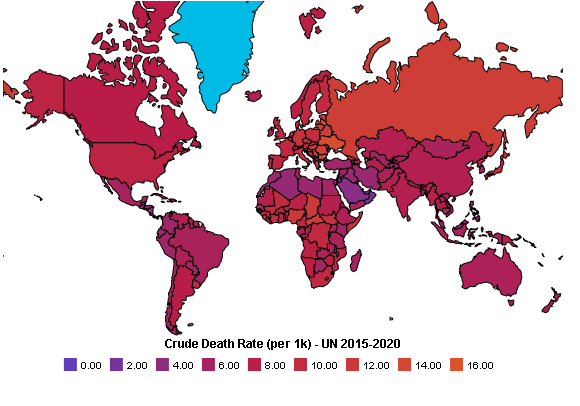
<br>
Death Rate from 2015-2020 [$^{[11]}$](https://worldpopulationreview.com/country-rankings/death-rate-by-country)

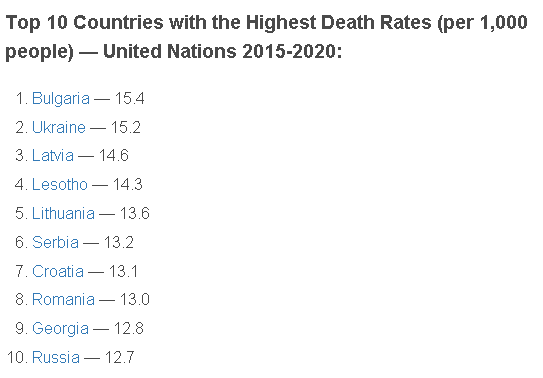
<br>
Top 10 Countries with the highest Death Rates from 2015-2020[$^{[12]}$](https://worldpopulationreview.com/country-rankings/death-rate-by-country)

Over the years, the ranking may have changed but the report could still provide insight as to why the death rates are so high for certain countries, according to worldpopulationreview.com:[$^{[13]}$](https://worldpopulationreview.com/country-rankings/death-rate-by-country)

> - "According to the CDC, the life expectancy at birth in Lesotho is 56 years for females and 52 years for males. The infant mortality rate is 59 per 1,000 live births. The leading causes of death are HIV/AIDS, tuberculosis, stroke, lower respiratory infections, and ischemic heart disease."

> - "Overall, Ukraine's health care system is poorly financed, and the country has very low vaccination rates and high rates of diseases and disorders that could be better managed with increased funding. One factor contributing to the mortality rate is the high death rate of working-age males from preventable causes such as alcohol poisoning and smoking."

> - "According to the World Health Organization, the causes of death in Bulgaria are similar to those in other European countries, including non-communicable diseases (diseases of the circulatory, digestive, or respiratory systems) and cancers."

<a id="14"></a>
<h1 style="font-size: 135%">D) Countries with the Lowest Death Rates</h1>

In [27]:
%%sql 
SELECT name, 
       death_rate
FROM facts
WHERE name != 'World'
AND death_rate IS NOT NULL
ORDER BY 2
LIMIT 10;

 * sqlite:///factbook.db
Done.


name,death_rate
Qatar,1.53
United Arab Emirates,1.97
Kuwait,2.18
Bahrain,2.69
Gaza Strip,3.04
Turks and Caicos Islands,3.1
Saudi Arabia,3.33
Oman,3.36
Singapore,3.43
West Bank,3.5


Qatar has the lowest death rate in the world at 1.53 annual births per 1000 people per year, followed by United Arab Emirates and Kuwait. According to the worldpopulationreview.com:

> - "Countries with low mortality rates have more advanced and accessible health care, better-informed citizens, healthier nutritional options, and higher living standards overall. Qatar has the lowest mortality rate. This low mortality rate can be attributed to Qatar's improved health care system, renowned for its technologically advanced facilities and ability to deliver some of the world's best patient care.[$^{[14]}$](https://worldpopulationreview.com/country-rankings/death-rate-by-country)"

<a id="15"></a>
<h1 style="font-size:160%"> Population Decline by Country</h1>

***

The following factors contribute to declining populations:
- Litte to negative population growth
    - A death ratio under 1
    - A migration rate under 1

In [28]:
%%sql 
WITH T1 AS (SELECT name
                        FROM facts
                        WHERE population =0
                        OR population IS null
                        OR area_land= 0
                        OR area_land IS null),
T2 AS(SELECT  name,
        area_land,
        population,
        ROUND((birth_rate / death_rate), 2) AS birth_death_ratio,
        population_growth,
        migration_rate,
        ROUND(percent_rank() over(ORDER BY area_land ASC)*100,2) as land_percentile,
        ROUND(percent_rank() over(ORDER BY population ASC)*100,2) as pop_percentile,
        ROUND(CAST(population AS FLOAT)/ CAST(area_land AS FLOAT),3) AS population_density
FROM facts
WHERE name NOT IN t1),

T3 AS(SELECT *
FROM T2
WHERE land_percentile > 31
AND pop_percentile > 10)

SELECT name,
       population_growth,
       birth_death_ratio,
       migration_rate
FROM T3
WHERE birth_death_ratio < 1
AND migration_rate < 1
ORDER BY 2,3,4;


 * sqlite:///factbook.db
Done.


name,population_growth,birth_death_ratio,migration_rate
Poland,0.09,0.96,0.46
Bosnia and Herzegovina,0.13,0.91,0.38
Japan,0.16,0.83,0.0
Belarus,0.2,0.8,0.7
Slovenia,0.26,0.74,0.37
Romania,0.3,0.77,0.24
Serbia,0.46,0.66,0.0
Bulgaria,0.58,0.62,0.29


Most countries in the table are located in or near Eastern Europe.  The population decline has been brought about by two key geopolitical events: the collapse of the Soviet Union and the enlargement of the European Union. These events allowed greater movement of citizens amongst former Soviet states. Moreover, joining the European Union allowed freer movement of people and has encouraged many citizens to look for opportunities elsewhere.[$^{[15]}$](https://globalriskinsights.com/2019/10/population-decline-in-central-and-eastern-europe/) In addition, the fertility rate is not high enough to match the emigration rate, which is reflected in the low birth to death ratio as well as the decline of population.

There are a few limitations using only population growth rate, birth to death ratio and migration rate to make conclusions for decline in population. The more common practice would be recording these rates over a longer period of time to avoid sudden spikes in population due to diseases or a decline of population for very specific age group. For example:

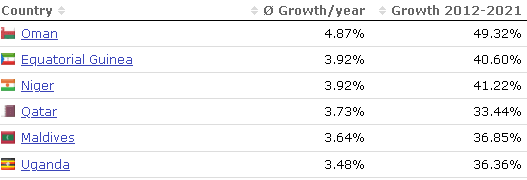
<br>
List of countries by population growth rate [$^{[16]}$](https://www.worlddata.info/populationgrowth.php?from=2012&to=2021)

Another key information that is missing is the age structure. In order to have a more consistent read or prediction of the birth to death ratio, age strucutre gives a good understanding of whether the country has a healthy demographic pyramid, which could translate into better insight of population growth.

<a id="16"></a>
<h1 style="font-size:160%">Conclusion</h1>

***

- The top 5 countries are responsible for 47% of the global population. They are China,India,United Sates, Indonesia and Brazil. China has the most population at 3 billion 4 hundred million, 19% of the global population.
- Areas such as Macau,Monaco,Singapore and Hong Kong are the most densely populated places in the world due to their exteremly small land area. From a national perspective, Bangladesh is the most densely populated country in the world followed by Taiwan, Rwanda and South Korea.
- Fertility rate is the highest in Africa, and lowest in Europe and Asia. Mortality rate is the highest in African countries and European countries, and the lowest in the Gulf cooperation countries of the Middle-East. 
- Population decline is the most precipitous in or near Eastern Europe due to the collapse of the Soviet Union, the enlargement of the European Union and a low birth rate that could not match the emigration rate.

<a id="17"></a>
<h1 style="font-size:160%">References</h1>

***

    1.Central Intelligence Agency. Central Intelligence Agency. Accessed November 24, 2022. https://www.cia.gov/the-world-factbook/. 
    
    2.“The World Factbook.” Wikipedia. Wikimedia Foundation, November 19, 2022. https://en.wikipedia.org/wiki/The_World_Factbook#:~:text=Entities%20listed,-Main%20article%3A%20List&amp;text=The%20CIA%20defines%20these%20as,category%2C%20there%20are%20195%20entities.&amp;text=Places%20set%20apart%20from%20the,Taiwan%20and%20the%20European%20Union. 
    
    3.“Current World Population.” Worldometer. Accessed November 24,2022. https://www.worldometers.info/world-population/. 
    
    4.“Antarctica.” National Geographic Society. Accessed November 24, 2022. https://education.nationalgeographic.org/resource/antarctica. 
    
    5.“World Population by Year.” Worldometer. Accessed November 24,2022. https://www.worldometers.info/world-population/world-population-by-year/. 
    
    6.“Population Density.” National Geographic Society. Accessed November 24, 2022. https://education.nationalgeographic.org/resource/population-density. 

    7.“Western Sahara.” Wikipedia. Wikimedia Foundation, November 17, 2022. https://en.wikipedia.org/wiki/Western_Sahara. 
    
    8.Alex Ezeh Dornsife Endowed Professor of Global Health, and Garumma Tolu Feyissa Researcher Dornsife School of Public Health. “What's Driving Africa's Population Growth. and What Can Change It.” The Conversation, November 18, 2022. https://theconversation.com/whats-driving-africas-population-growth-and-what-can-change-it-126362#:~:text=These%20questions%20can%20best%20be,high%20levels%20of%20adolescent%20childbearing. 
    
    9.McDonald, Peter, Zhongwei Zhao, Noriko Tsuya, Srinivas Goli, Masataka Nakagawa, Chen Bai, EAF Editors, et al. “Very Low Fertility: An East Asian Dilemma.” East Asia Forum, March 13, 2015. https://www.eastasiaforum.org/2013/04/23/very-low-fertility-an-east-asian-dilemma/. 
    
    10.Cost of living (no date) Cost of Living. Available at: https://www.numbeo.com/cost-of-living/region_rankings_current.jsp?region=035 (Accessed: November 25, 2022). 
    
    11.Death rate by country 2022. Available at: https://worldpopulationreview.com/country-rankings/death-rate-by-country (Accessed: November 25, 2022). 
    
    12. Ibid.
    
    13. Ibid.
    
    14. Ibid
    
    15. Population decline in central and Eastern Europe (2019) Global Risk Insights. Available at: https://globalriskinsights.com/2019/10/population-decline-in-central-and-eastern-europe/ (Accessed: November 25, 2022). 
    
    16. “Comparison: Population Growth by Country.” Worlddata.info. Accessed December 5, 2022. https://www.worlddata.info/populationgrowth.php?from=2012&amp;to=2021. 